<a href="https://colab.research.google.com/github/patriani/Curso_Git-1/blob/master/MDDescritiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#Une os dados do datasus (CSVs distintos) em uma só tabela -- VERIFICADO
import pandas as pd

# lendo os arquivos de dados do DATASUS (CSV's)
area = pd.read_csv('DATASUS/area.csv', sep = ",", encoding='latin-1', na_filter=False)
ocupacao = pd.read_csv('DATASUS/ocupacao.csv', sep = ",", encoding='latin-1', na_filter=False)
escolaridade = pd.read_csv('DATASUS/escolaridade.csv', sep = ",", encoding='latin-1', na_filter=False)

# função "merge" para inner join: how='inner' (https://acervolima.com/como-mesclar-dois-arquivos-csv-por-coluna-especifica-usando-pandas-em-python/)
bd1 = pd.merge(area, ocupacao, on='Município de notificação',how='left') 
bd2 = pd.merge(bd1, escolaridade, on='Município de notificação',how='left') 
print(bd2)
# converte resultado para csv
bd2.to_csv('DATASUS/bd.csv')

#verificando consistência da junção
bd = pd.read_csv('DATASUS/bd.csv', sep = ",", encoding='latin-1',usecols=['Total_x','Total_y','Total'], na_filter=False)
cols1 = bd.loc[bd['Total_x'] != bd['Total_y']]
ok = False
if cols1.empty:
  cols2 = bd.loc[bd['Total_y'] != bd['Total']]
  if cols2.empty:
    print("união DATASUS ok")
    ok = True
  else:
    print("erro na união 2")
else:
  print("erro na união 1")
if ok == True: #dessa forma o resultado da união é salvo assim que validada
  (bd2.drop(columns=["Total_x","Total_y"])).to_csv('DATASUS/bd.csv')
  #apaga linha de "total" que ficou oblíqua  
  (bd2.drop(bd2.index[293])).to_csv('DATASUS/bd.csv')

In [ ]:
# trata valores representados por "-" -- VERIFICADO
import pandas as pd

car_datasus = pd.read_csv('car_datasus.csv', sep = ",", encoding='latin-1', na_filter=False)
car_datasus = car_datasus.replace("-",0)
car_datasus.to_csv('datasus_ok.csv')

In [ ]:
# A partir das estimativas populacionais de 2008, 2014 e 2021 foi calculada
#a media e com ela a densidade populacional, possibilitada pelo csv de area municipal
# -- VERIFICADA 
import pandas as pd

# Abrir arquivos de estimativa da população e uni-los em: 'base.csv'
pop_2021 = pd.read_csv('pop_2021.csv', sep = ",", encoding='latin-1', na_filter=False)
pop_2008 = pd.read_csv('pop_2008.csv', sep = ",", encoding='latin-1', na_filter=False)
pop_2014 = pd.read_csv('pop_2014.csv', sep = ",", encoding='latin-1', na_filter=False)

# Somar 3500000 para que o Cod de município fique no formato do IBGE
pop_2021["Cod Mun"] = pop_2021["Cod Mun"] + 3500000
pop_2008["Cod Mun"] = pop_2008["Cod Mun"] + 3500000
pop_2014["Cod Mun"] = pop_2014["Cod Mun"] + 3500000

# União pelo código em comum: Cod Mun 
# "left: use only keys from left frame, similar to a SQL left outer join; preserve key order."
# A união começa com o pop_2008 por ter menos registros que os demais anos
nova_base = pd.merge(pop_2008, pop_2014, on='Cod Mun',how='left') 
nova_base = pd.merge(nova_base, pop_2021, on='Cod Mun',how='left') 

#obs: essa soma não funciona caso a coluna do csv não esteja configurada como um tipo numérico
nova_base['frequencia acumulada'] = nova_base['Pop 2008']+nova_base['Pop_2014']+nova_base['Pop_2021']

# abrir arquivo com km2 dos municipios e calcular a densidade média dos anos
km2 = pd.read_csv('km2.csv', sep = ",", encoding='latin-1', na_filter=False)
nova_base = pd.merge(nova_base, km2, on='Cod Mun',how='left') 

# criar coluna para frequência relativa (freq acumulada(csv1+csv2+csv3) / 3 -> numero de colunas) da população e calcular
nova_base['frequencia relativa'] = round( nova_base['frequencia acumulada']/3 , 2 )

# dividir a frequencia relativa pela área do município
#print(nova_base)
nova_base['Densidade Populacional'] = round(nova_base['frequencia relativa'] /  nova_base['area (Em km2)'],2)

#remover todas as colunas duplicadas e não interessantes para a pesquisa (a união das tabelas trouxe muita informação irrelevante)
(nova_base.drop(columns=["Sigla_x","Cod UF_x","Nome_x","Nome_y","Nome","Pop 2008","Sigla_y","Cod UF_y","Pop_2014","Sigla","Pop_2021","frequencia acumulada","frequencia relativa","area (Em km2)","Cod UF"])).to_csv('Dens_pop.csv')


In [ ]:
#------------------Une códigos a munic. de tabela com IDHM
#Executar as instalações abaixo em todas as vezes que o ambiente for reciclado

# -- VERIFICADA: revisão [1]


# !pip install fuzzywuzzy 
# !pip install python-Levenshtein  
from fuzzywuzzy import fuzz
import pandas as pd
import numpy as np

codigos = pd.read_csv('codigos.csv', sep = ";", encoding='latin-1', na_filter=False)
idhm = pd.read_csv('idhm_limpo.csv', sep = ",", encoding='latin-1', na_filter=False)

temp = [] # armazena códigos não atribuídos
count = 0 # número de códigos não atribuídos
df = pd.DataFrame(index=range(0,644),columns=['Id Cod', 'Cod Mun', 'Nome Mun','IDHM 2000','IDHM 2010']) # concatenar coluna de código com o DF de IDHM
fuz = []
for index_idhm, row_idhm in idhm.iterrows():
  for index_codigos, row_codigos in codigos.iterrows():
    #simplifica o texto capturado
    str_idhm = row_idhm['Nome Mun'].lower()
    str_idhm = str_idhm.replace(" ", "")
    str_idhm = str_idhm.replace("(sp)", "")
    str_cod = row_codigos['Nome Mun'].lower()
    str_cod = str_cod.replace(" ", "")
    str_cod = str_cod.replace("(sp)", "")
    #confere similaridade
    if(fuzz.ratio(str_cod,str_idhm) > 90): # a ordem da comparação faz com que o (SP) em cada nome do DF idhm não abaixe a similaridade
      df['Id Cod'].loc[index_idhm] = index_codigos
      df['Cod Mun'].loc[index_idhm] = row_codigos['Cod Mun']
      df['Nome Mun'].loc[index_idhm] = row_codigos['Nome Mun']
      df['IDHM 2000'].loc[index_idhm] = row_idhm['idhm2000']
      df['IDHM 2010'].loc[index_idhm] = row_idhm['idhm2010']
      #remove linha para evitar leitura duplicada
      codigos = codigos.drop(index_codigos)
      if(str_idhm in temp):
        temp.remove(str_idhm)
      break # itera o idhm para continuar busca 
    else:
        count += 1
        temp.append(row_codigos['Cod Mun']) # armazena código da linha ignorada
        continue
print('Municipios sem código IBGE:')
for index, row_df in df.iterrows(): # percorre o DataFrame gerado a procura de linha com NaN
  if(np.isnan(row_df['Cod Mun'])):
    df = df.drop(index)
    print(idhm['Nome Mun'].loc[index]) # captura o indice da linha com NaN e "printa" o Nome do Município da tabela de IDHM original
#obs: até a remoção de uma linha as tabelas df e idhm possuiam a mesma dimensão
df.to_csv('df.csv', sep = ";")


In [ ]:
#------------ Calcula IDHM médio = [(2000+2010)/2] 
# -- VERIFICADA 

import pandas as pd

#df é o DataFrame que foi armazenado em CSV na etapa de agrupamento de código municipio + idhm
res_calculo = pd.read_csv('df.csv', sep = ";", encoding='latin-1', na_filter=False)

#df: após gerado precisa ser tratado manualmente para transformar para lingua inglesa (ponto como separador de casa decimal)
res_calculo['freq_rel'] = (res_calculo['IDHM 2000'] + res_calculo['IDHM 2010'])/2

(res_calculo.drop(columns=['IDHM 2000','IDHM 2010'])).to_csv('idhm_rel.csv', sep = ";")
print(res_calculo)

In [ ]:
#Une todos os csv tratados anteriormente para formar uma só base
# -- VERIFICADA: revisão[2]

import pandas as pd
import numpy as np

datasus = pd.read_csv('datasus_ok.csvc', sep = ",", encoding='latin-1', na_filter=False)
densidade = pd.read_csv('dens_pop.csv', sep = ",", encoding='latin-1', na_filter=False)
idhm_rel = pd.read_csv('idhm_rel.csv', sep = ";", encoding='latin-1', na_filter=False)

#remove indexação não utilizada
c1 = datasus.columns[0]
c2 = datasus.columns[1]
datasus = datasus.drop(columns=[c1,c2])

#renomeia coluna de código IBGE de datasus ([string_complexa] para ['Cod Mun'])
c1 = datasus.columns[0]
datasus.rename(columns={c1: 'Nome Mun'}, inplace=True)

#separando código IBGE do nome municipio em datasus
datasus['Cod Mun'] = [x.split(' ')[0] for x in datasus['Nome Mun']]

#transformando os campos para inteiro para comparação de código IBGE
datasus['Cod Mun'] = datasus['Cod Mun'].astype('int')
densidade['Cod Mun'] = densidade['Cod Mun'].astype('int')

# //10 (divisão por 10 sem resto) para que o formato do código fique como na tabela do DATASUS 
densidade['Cod Mun'] = densidade['Cod Mun']//10
idhm_rel['Cod Mun'] = idhm_rel['Cod Mun']//10

# print(type(densidade['Cod Mun']))
nova_base = pd.merge(datasus, densidade, on='Cod Mun',how='left') 
nova_base = pd.merge(nova_base, idhm_rel, on='Cod Mun',how='left') 

for index, row_nb in nova_base.iterrows(): # percorre o DataFrame gerado a procura de linha com NaN
  if(str(row_nb['Nome Mun_y'])== 'nan'):
    print(row_nb['Municipio']) #relata o municipio faltante
    nova_base = nova_base.drop(index)

nova_base.to_csv('base.csv')

Embu das Artes
Taquaral


In [ ]:
#remover colunas duplicadas e renomear remanescentes
# -- VERIFICADA 

import pandas as pd

base = pd.read_csv('base.csv', sep = ",", encoding='latin-1', na_filter=False)
#Remoção
selecao=['Unnamed: 0','Nome Mun_x','Total_y','Total_x','Unnamed: 0_x','Unnamed: 0_y','Nome Mun_y']
base = base.drop(columns = selecao)

#Renom
c0 = base.columns[9]
c1 = base.columns[11]
c2 = base.columns[12] #4 serie EF completa
c3 = base.columns[13] #5a8 serie EF incompleta
c4 = base.columns[14] #EF completo
c5 = base.columns[15] #EM incompleto
c6 = base.columns[16] #EM completo
c7 = base.columns[17] #ES incompleto
c8 = base.columns[18] #ES completo
c9 = base.columns[19] #Nao se aplica

base.rename(columns={c0:'Ign/Branco_z',c1: '1a4 serie EF incompleto',c2:'4 serie EF completa',
                     c3:'5a8 serie EF incompleta',c4:'EF completo',c5:'EM incompleto',c6:'EM completo',c7:'ES incompleto',
                     c8:'ES completo',c9:'Nao se aplica'}, inplace=True)
#grava no csv
base.to_csv('renom.csv')
# NOTA: colunas de municipio e código são mantidas para leitura mas não entrarão de fato na análise

Início do tratamento para mineração:

In [ ]:
#Função que faz 5 combinações de normalização dos dados -- coluna de total removida

import pandas as pd
import numpy as np
import scipy.stats as stats

def normalizacao(matriz_hierarquica):

  #definindo colunas para diferentes tipos de normalização
  columns1 = ['Ign/Branco_x', 'Urbana', 'Rural', 'Periurbana', 'Ign/Branco_y',
        'Domiciliar', 'Trabalho', 'Lazer', 'Outro', 'Ign/Branco_z',
        'Analfabeto', '1a4 serie EF incompleto', '4 serie EF completa',
        '5a8 serie EF incompleta', 'EF completo', 'EM incompleto',
        'EM completo', 'ES incompleto', 'ES completo', 'Nao se aplica'] #, 'Total'

  columns2 = ['Densidade Populacional']

  columns3 = ['Ign/Branco_x', 'Urbana', 'Rural', 'Periurbana', 'Ign/Branco_y',
        'Domiciliar', 'Trabalho', 'Lazer', 'Outro', 'Ign/Branco_z',
        'Analfabeto', '1a4 serie EF incompleto', '4 serie EF completa',
        '5a8 serie EF incompleta', 'EF completo', 'EM incompleto',
        'EM completo', 'ES incompleto', 'ES completo', 'Nao se aplica','Densidade Populacional','freq_rel'] #, 'Total'

  columns4 = ['freq_rel']

  df = pd.DataFrame(matriz_hierarquica) 

  norm1 = stats.zscore(df[columns1]) # DATASUS normalizado
  norm2 = stats.zscore(df[columns2]) # apenas a de densidade populacional
  norm3 = stats.zscore(df[columns3]) # todas
  norm_temp = stats.zscore(df[columns4])
  
  norm5 = df.drop(columns=['Densidade Populacional', 'freq_rel'])
  norm5['Densidade Populacional'] = norm2
  norm5['freq_rel'] = norm_temp

  norm4 = norm1
  norm4['Densidade Populacional'] = norm5['Densidade Populacional']
  norm4['freq_rel'] = df['freq_rel']
  new_norm4 = norm4.copy()

  # inclui nos dataframes de normalização as colunas não abordadas pelo zscore
  norm1['Densidade Populacional'] = df['Densidade Populacional']
  norm1['freq_rel'] = df['freq_rel']
  
  new_norm2 = df.drop(columns=['Densidade Populacional','freq_rel']) #primeiro recebe colunas iniciais do dataframe original 
  new_norm2['Densidade Populacional'] = norm2
  new_norm2['freq_rel'] = df['freq_rel']

  norm3.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/norm3.csv')

  return norm1,new_norm2,norm3,new_norm4,norm5

#-------------------------------------------------TESTE DA FUNÇÃO-------------------------------------------
# df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/renom.csv', delimiter = ',')

# #removendo colunas que não participam da análise computacional 
# matriz_hierarquica = df.drop(columns=['Unnamed: 0','Cod Mun','Municipio']) #remove coluna de indices

# # matriz_hierarquica = matriz_hierarquica.drop(matriz_hierarquica.index[290])

# norm1,norm2,norm3,norm4,norm5 = normalizacao(matriz_hierarquica)

# data_norm_dic = {'norm1':norm1.to_numpy(),'norm2':norm2.to_numpy(),'norm3':norm3.to_numpy(),'norm4':norm4.to_numpy(),'norm5':norm5.to_numpy()}

# norm3.head()

In [ ]:
# inserindo dados em dataframe puro de respostas (análise comparativa de resultados)
import pandas as pd

#df: dataframe de resultado
#index: linha correspondente do dataframe
#method: método de separação dos clusters
#norm: formato de normalização dos dados
#k: numero de clusters
#silh: pontuação da validação (silhueta)

## Por meio do índice de iteração o DataFrame é incrementado. Função recebe e o retorna
def insert_res(df,index,method,norm,k,silh): 
  if(df is 'null'):
    df = pd.DataFrame(columns=['index','algoritmo','method','normalization','n_Ks','silhouette_avg'])
  elif(method is 'kmeans'):
    df.loc[index] = [index,'kmeans','-',norm,k,silh]
  else:
    df.loc[index] = [index,'hierarquico',method,norm,k,silh]
  return df

In [ ]:
from sklearn.cluster import KMeans

def kmeans_alg(df,k):
  kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10)
  clusters = kmeans.fit_predict(df)
  return clusters

In [ ]:
# percorre DataFrame em busca de valores iguais ao maior
def maiores_semelhantes(df_res,maxS):
  temp = df_res['silhouette_avg']
  ids = []
  c = 1
  for i in temp:
    c += 1
    if(i >= maxS):
      ids.append(c)
  print('Maiores Semelhantes:',ids)

In [ ]:
## Corrigindo dados de Votuporanga: estava sem nome do municipio e sem Densidade Populacional
import pandas as pd
import numpy as np

## Importar csv como DataFrame numpy
df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/renom.csv', delimiter = ',')

# col = df.columns
# temp = pd.DataFrame(columns=col)
df = df.fillna(0.0)


df.loc[290, ('Municipio')] = 'Votuporanga' #utilizar " df.loc[290]['Municipio'] " falha pois o pandas vê como dois acessos individuais
df.loc[290, ('Densidade Populacional')] = 222.9


df.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/renom.csv')


In [ ]:
#teste 3 de hierarquico: com normalizações
# -- VERIFICADA: revisão[3]

!pip install matplotlib
!pip install sklearn

import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering #algoritmo de clusterização
from sklearn.metrics import silhouette_samples, silhouette_score #método para validação será silhueta


## Importar csv como DataFrame numpy
df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/renom.csv', delimiter = ',')
# df = df.drop(252) #teste sem linha do mun São Paulo (outlier)


## Removendo colunas que não participam da análise computacional:
matriz_hierarquica = df.drop(columns=['Unnamed: 0','Cod Mun','Municipio','Total']) 


## Remover linhas com dados faltantes:
# matriz_hierarquica = matriz_hierarquica.drop(matriz_hierarquica.index[290]) #linha removida temporariamente para teste (está sem a densidade pop -> adicionar)
# matriz_hierarquica = matriz_hierarquica.drop(matriz_hierarquica.index[289]) #linha removida temporariamente para teste (está sem a densidade pop -> adicionar)


## Criando dataframe para visualização dos resultados e inserção no banco de dados:
df_raw = df.copy() #salvando uma instancia para gerar uma base de dados classificados
df_raw = df_raw.drop(columns=['Unnamed: 0','Total'])
# df_raw = df_raw.drop(df_raw.index[289]) # a ultima linha não possui idhm ainda 
# df_raw = df_raw.drop(df_raw.index[290]) # a ultima linha não possui idhm ainda 


## Chama função para gerar combinações de normalizações:
data_norm1,data_norm2,data_norm3,data_norm4,data_norm5 = normalizacao(matriz_hierarquica)
data_norm_dic = {'raw':matriz_hierarquica.to_numpy(),'norm1':data_norm1.to_numpy(),'norm2':data_norm2.to_numpy(),'norm3':data_norm3.to_numpy(),'norm4':data_norm4.to_numpy(),'norm5':data_norm5.to_numpy()} #cria dicionario com as diferentes normalizações, inclusive sem normalização (raw)


## Vetor que carrega métodos de hierarquica + kmeans (todos utilizam euclidiana -> melhor para dados normalizados):
methods = ["complete", "average",'ward','kmeans'] #, "single" removido por não ser sensível a dados globulares e CORRELAÇÃO sensível a outliers

## Inicialização do restante das variáveis para identificar o melhor resultado segundo a silhueta:
c = 0 #:contador para prints organizados
maxC = c
maxS = 0
maxN = 'null'
df_res = 'null'
label_column = [] # clusters do melhor resultado

for method in methods: 
  for key, value in data_norm_dic.items() : # cada algoritmo utiliza todos os tipos de normalização
    for k in range(2,8): # para cada normalização é feita uma análise sobre o número de clusters [2,7]
      c += 1
      if(method is 'kmeans'):
        cluster_labels = kmeans_alg(value,k)
      else:  
        model = AgglomerativeClustering(affinity = 'euclidean', linkage = method, n_clusters = k) # construtor de clusterização hierarquica (affinity: métrica para computar as distâncias entre clusters)
        cluster_labels = model.fit_predict(value) # retorna os clusters (fit & predict em apenas um passo)
      silhouette_avg = silhouette_score(value, cluster_labels) # aplica silhueta para validação
      df_res = insert_res(df_res,c,method,key,k,silhouette_avg) # DataFrame é incrementado para cada instância
      if silhouette_avg > maxS:
        maxC = c
        maxS = silhouette_avg
        maxN = key
        label_column = cluster_labels

print(f"melhor resultado é o caso {maxC}")
print('')
print(df_res.loc[maxC])

maiores_semelhantes(df_res,maxS)

## Formação dos CSVs:
df_raw['clusters'] = label_column

# df_res.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/hierarquica_res.csv')
df_res.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/analisa_algoritmos.csv') # isntâncias de resultados e resultados perante validação 
df_raw.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/classificados.csv') # classificações


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
melhor resultado é o caso 25

index                      25
algoritmo         hierarquico
method               complete
normalization           norm4
n_Ks                        2
silhouette_avg       0.966746
Name: 25, dtype: object
Maiores Semelhantes: [25, 61, 97, 133]


Pós Processamento

In [ ]:
## função para retornar quais algoritmos deram silhueta maior que 0,70
# TO-DO: com esse resultado rodar os algoritmos e guardar os labels
import re
import pandas as pd

df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/analisa_algoritmos.csv', delimiter = ',')

best_res = pd.DataFrame(columns=['Unnamed: 0','index','algoritmo','method','norm','n_Ks','silhouette_avg'])
index = 0

# percorre dataframe
# if coluna:normalization = 'norm3' & coluna:n_Ks != 2 (todos com k=2 estão ruins)
#   if silhouette_avg > 0.7 --> confirmar fonte dessa decisão
#     coloca linha em um novo dataframe (best_res)

for df_index, df_row in df.iterrows():
  temp = re.sub(r"\s+", "", df_row['normalization'])
  if((temp == 'norm3') and (df_row['n_Ks'] >= 2)):
    if(df_row['silhouette_avg'] > 0.7):
      best_res.loc[index] = df_row
      index += 1
best_res.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/best_res.csv')
print(best_res)

   Unnamed: 0 index    algoritmo    method  norm n_Ks  silhouette_avg
0          19    19  hierarquico  complete   NaN    2        0.958653
1          20    20  hierarquico  complete   NaN    3        0.862498
2          21    21  hierarquico  complete   NaN    4        0.817375
3          22    22  hierarquico  complete   NaN    5        0.798631
4          23    23  hierarquico  complete   NaN    6        0.726240
5          55    55  hierarquico   average   NaN    2        0.958653
6          56    56  hierarquico   average   NaN    3        0.862498
7          57    57  hierarquico   average   NaN    4        0.817375
8          58    58  hierarquico   average   NaN    5        0.798631
9          59    59  hierarquico   average   NaN    6        0.726240
10         91    91  hierarquico      ward   NaN    2        0.958653
11         92    92  hierarquico      ward   NaN    3        0.838457
12        127   127       kmeans         -   NaN    2        0.958653
13        128   128 

In [ ]:
## rodando apenas algoritmos retornados pela análise acima: objetivo é obter classificadores deles -> salva rotulos em csv
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering #algoritmo de clusterização

def matLabels():
  norm3 = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/norm3.csv', delimiter = ',')
  norm3 = (norm3.to_numpy()).copy()
  mat_labels = [ [] for i in range(14) ] #cria matriz de arrays (10 arrays = 10 listas de classificadores)
  i = 0 #index da matriz acima
  
  # norm3 = norm3.drop(columns=['Total']) -> removida no código de normalização

  ## loop para melhores resultados de complete com norm3
  for k in range(2,7):
    model = AgglomerativeClustering(affinity = 'euclidean', linkage = 'complete', n_clusters = k) # construtor de clusterização hierarquica (affinity: métrica para computar as distâncias entre clusters)
    mat_labels[i] = model.fit_predict(norm3) # retorna os clusters (fit & predict em apenas um passo)
    i += 1
  ## loop para melhores resultados de avarage com norm3
  for k in range(2,7):
    model = AgglomerativeClustering(affinity = 'euclidean', linkage = 'average', n_clusters = k) # construtor de clusterização hierarquica (affinity: métrica para computar as distâncias entre clusters)
    mat_labels[i] = model.fit_predict(norm3) # retorna os clusters (fit & predict em apenas um passo)
    i += 1
  ## melhor resultado do ward para norm3
  for k in range(2,4):
    model = AgglomerativeClustering(affinity = 'euclidean', linkage = 'ward', n_clusters = k) # construtor de clusterização hierarquica (affinity: métrica para computar as distâncias entre clusters)
    mat_labels[i] = model.fit_predict(norm3) # retorna os clusters (fit & predict em apenas um passo)
    i += 1
  ## melhor resultado do k-means para norm3
  
  mat_labels[i] = kmeans_alg(norm3,2)
  i += 1
  mat_labels[i] = kmeans_alg(norm3,3) #analisando a matriz de melhores resultados para o norm3, kmeans tem seu resultado com k = 3

  return mat_labels

def melhoresRotulos(): #faz csv com melhores rotulos + caracteristicas não normalizadas (aplicar correção e boxplot)
  mat_labels = matLabels()
  df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/renom.csv', delimiter = ',')
  df['complete_2'] = mat_labels[0]
  df['complete_3'] = mat_labels[1] #como os rotulos foram inseridos do começo ao fim da lista então o primeiro elemento da matriz é o complete com k = 3
  df['complete_4'] = mat_labels[2]
  df['complete_5'] = mat_labels[3]
  df['complete_6'] = mat_labels[4]
  df['avarage_2'] = mat_labels[5] 
  df['avarage_3'] = mat_labels[6]
  df['avarage_4'] = mat_labels[7]
  df['avarage_5'] = mat_labels[8]
  df['avarage_6'] = mat_labels[9]
  df['ward_2'] = mat_labels[10]
  df['ward_3'] = mat_labels[11]
  df['kmeans_2'] = mat_labels[12]
  df['kmeans_3'] = mat_labels[13]  
  
  df.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/melhores_rotulos.csv')
  df.to_csv('melhores_rotulos.csv')
  return df
  
melhoresRotulos()

In [6]:
import pandas as pd

df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/melhores_rotulos.csv', delimiter = ',')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Ign/Branco_x', 'Urbana', 'Rural', 'Periurbana', 'Ign/Branco_y',
       'Domiciliar', 'Trabalho', 'Lazer', 'Outro', 'Ign/Branco_z',
       'Analfabeto', '1a4 serie EF incompleto', '4 serie EF completa',
       '5a8 serie EF incompleta', 'EF completo', 'EM incompleto',
       'EM completo', 'ES incompleto', 'ES completo', 'Nao se aplica', 'Total',
        'Municipio',
       'complete_2', 'complete_3', 'complete_4', 'complete_5', 'complete_6',
       'avarage_2', 'avarage_3', 'avarage_4', 'avarage_5', 'avarage_6',
       'ward_2', 'ward_3', 'kmeans_2', 'kmeans_3'])
df.head()

,Cod Mun,Densidade Populacional,freq_rel
0,350010,84.77,0.7555
1,350030,72.63,0.6785
2,350040,56.17,0.7365
3,350050,296.97,0.7200
4,350070,37.89,0.7070


In [ ]:
## aplicando boxplot
## interpretações: https://statplace.com.br/blog/como-interpretar-um-boxplot/#:~:text=Como%20interpretar%20o%20boxplot%3F,a%20mediana%20ou%20segundo%20quartil).
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from textwrap import wrap


def n_outliers(col,df_temp):
  bp = None
  count = 0

  # fig, axs = plt.subplots(2, 3)

  # basic plot
  # axs[0, 0].boxplot(df_temp[col],notch=True,vert=False,showcaps=True)
  # axs[0, 0].set_title('basic plot')

  bp = plt.boxplot(df_temp[col],notch=True,vert=False,showcaps=True)
  array = [item.get_ydata() for item in bp['fliers']]
  for sub in array:
    count += len(sub)
  return count

# def correlacao(df_temp,df,cols): # tentativa de correlação da coluna 'urbana' do grupo 0 em relação ao DF gerador dos clusters
#   # var = df_temp.corrwith(df,axis=1)
#   df_temp2 = pd.DataFrame()
#   for col in cols:
#     df_temp2[col] = df[col]
#   corr_urb_grupo0 = df_temp.corrwith(df_temp2,axis = 1)
#   print(corr_urb_grupo0)

df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/melhores_rotulos.csv',delimiter = ',')

# gerar dataframe:
## dataframe de algoritmo:k com columns = (nome coluna cluster - df) + numero outliers -> adicionar soma ao final da análise

#Colunas não incluidas na análise: 'Cod Mun' & 'Municipio'
cols = ['Ign/Branco_x',
       'Urbana', 'Rural', 'Periurbana', 'Ign/Branco_y', 'Domiciliar',
       'Trabalho', 'Lazer', 'Outro', 'Ign/Branco_z', 'Analfabeto',
       '1a4 serie EF incompleto', '4 serie EF completa',
       '5a8 serie EF incompleta', 'EF completo', 'EM incompleto',
       'EM completo', 'ES incompleto', 'ES completo', 'Nao se aplica', 'Densidade Populacional', 'freq_rel'] # , 'Total'

complete_2_outliers = pd.DataFrame(0,index=range(0,2),columns=cols)
complete_3_outliers = pd.DataFrame(0,index=range(0,3),columns=cols)
complete_4_outliers = pd.DataFrame(0,index=range(0,4),columns=cols)
complete_5_outliers = pd.DataFrame(0,index=range(0,5),columns=cols)
complete_6_outliers = pd.DataFrame(0,index=range(0,6),columns=cols)
avarage_2_outliers = pd.DataFrame(0,index=range(0,2),columns=cols)
avarage_3_outliers = pd.DataFrame(0,index=range(0,3),columns=cols)
avarage_4_outliers = pd.DataFrame(0,index=range(0,4),columns=cols)
avarage_5_outliers = pd.DataFrame(0,index=range(0,5),columns=cols)
avarage_6_outliers = pd.DataFrame(0,index=range(0,6),columns=cols)
ward_2_outliers = pd.DataFrame(0,index=range(0,2),columns=cols)
ward_3_outliers = pd.DataFrame(0,index=range(0,3),columns=cols)
kmeans_2_outliers = pd.DataFrame(0,index=range(0,2),columns=cols)
kmeans_3_outliers = pd.DataFrame(0,index=range(0,3),columns=cols)

# val = complete_3_outliers['Urbana'].empty
# print(val)
for alg in ['complete_2','complete_3', 'complete_4','complete_5', 'complete_6', 'avarage_2', 'avarage_3','avarage_4', 'avarage_5', 'avarage_6', 'ward_2','ward_3', 'kmeans_2', 'kmeans_3']: 
  string_vet = alg.split('_') #string_vet[0]: contém o nome do algoritmo e string_vet[1] contém o número de clusters
  for cluster in range(0,int(string_vet[1])):
    df_temp = pd.DataFrame()
    df_temp = df[df[alg] == cluster] #filtra pela coluna do algoritmo (alg) em questão e o cluster que está sendo analisado (cluster)
    for col in cols:
      if(string_vet[0] == 'complete'):
        if(string_vet[1] == '2'):
          complete_2_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
        if(string_vet[1] == '3'):
          complete_3_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
        if(string_vet[1] == '4'):
          complete_4_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
        if(string_vet[1] == '5'):
          complete_5_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
        if(string_vet[1] == '6'):
          complete_6_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
      elif(string_vet[0] == 'avarage'):
        if(string_vet[1] == '2'):
          avarage_2_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
        if(string_vet[1] == '3'):
          avarage_3_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
        if(string_vet[1] == '4'):
          avarage_4_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
        if(string_vet[1] == '5'):
          avarage_5_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
        if(string_vet[1] == '6'):
          avarage_6_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
      elif(string_vet[0] == 'ward'):
        if(string_vet[1] == '2'):  
          ward_2_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
        if(string_vet[1] == '3'):  
          ward_3_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
      elif(string_vet[0] == 'kmeans'):
        if(string_vet[1] == '2'): 
          kmeans_2_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
        if(string_vet[1] == '3'): 
          kmeans_3_outliers.loc[cluster,(col)] += n_outliers(col,df_temp)
      else:
        print('\n\nERRO\n\n')
# Contabilizando total de outliers por coluna e por grupo
complete_2_outliers['Total_grupo'] = complete_2_outliers.sum(axis=1)
complete_2_outliers.loc['Total_coluna'] = complete_2_outliers.sum(axis=0)

complete_3_outliers['Total_grupo'] = complete_3_outliers.sum(axis=1)
complete_3_outliers.loc['Total_coluna'] = complete_3_outliers.sum(axis=0)

complete_4_outliers['Total_grupo'] = complete_4_outliers.sum(axis=1)
complete_4_outliers.loc['Total_coluna'] = complete_4_outliers.sum(axis=0)

complete_5_outliers['Total_grupo'] = complete_5_outliers.sum(axis=1)
complete_5_outliers.loc['Total_coluna'] = complete_5_outliers.sum(axis=0)

complete_6_outliers['Total_grupo'] = complete_6_outliers.sum(axis=1)
complete_6_outliers.loc['Total_coluna'] = complete_6_outliers.sum(axis=0)

avarage_2_outliers['Total_grupo'] = avarage_2_outliers.sum(axis=1)
avarage_2_outliers.loc['Total_coluna'] = avarage_2_outliers.sum(axis=0)

avarage_3_outliers['Total_grupo'] = avarage_3_outliers.sum(axis=1)
avarage_3_outliers.loc['Total_coluna'] = avarage_3_outliers.sum(axis=0)

avarage_4_outliers['Total_grupo'] = avarage_4_outliers.sum(axis=1)
avarage_4_outliers.loc['Total_coluna'] = avarage_4_outliers.sum(axis=0)

avarage_5_outliers['Total_grupo'] = avarage_5_outliers.sum(axis=1)
avarage_5_outliers.loc['Total_coluna'] = avarage_5_outliers.sum(axis=0)

avarage_6_outliers['Total_grupo'] = avarage_6_outliers.sum(axis=1)
avarage_6_outliers.loc['Total_coluna'] = avarage_6_outliers.sum(axis=0)

ward_2_outliers['Total_grupo'] = ward_2_outliers.sum(axis=1)
ward_2_outliers.loc['Total_coluna'] = ward_2_outliers.sum(axis=0)

ward_3_outliers['Total_grupo'] = ward_3_outliers.sum(axis=1)
ward_3_outliers.loc['Total_coluna'] = ward_3_outliers.sum(axis=0)

kmeans_2_outliers['Total_grupo'] = kmeans_2_outliers.sum(axis=1)
kmeans_2_outliers.loc['Total_coluna'] = kmeans_2_outliers.sum(axis=0)

kmeans_3_outliers['Total_grupo'] = kmeans_3_outliers.sum(axis=1)
kmeans_3_outliers.loc['Total_coluna'] = kmeans_3_outliers.sum(axis=0)

complete_2_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/complete_2_outliers.csv')
complete_3_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/complete_3_outliers.csv')
complete_4_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/complete_4_outliers.csv')
complete_5_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/complete_5_outliers.csv')
complete_6_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/complete_6_outliers.csv')
avarage_2_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/avarage_2_outliers.csv')
avarage_3_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/avarage_3_outliers.csv')
avarage_4_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/avarage_4_outliers.csv')
avarage_5_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/avarage_5_outliers.csv')
avarage_6_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/avarage_6_outliers.csv')
ward_2_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/ward_2_outliers.csv')
ward_3_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/ward_3_outliers.csv')
kmeans_2_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/kmeans_2_outliers.csv')
kmeans_3_outliers.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/outliers/kmeans_3_outliers.csv')

In [ ]:
#ANÁLISE DE AGRUPAMENTOS DO COMPLETE COM K=2
import pandas as pd
import numpy as np

df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/melhores_rotulos.csv',delimiter = ',')

# definindo colunas que não são úteis para análise de correlação
cols = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'complete_3', 'complete_4', 'complete_5', 'complete_6',
       'avarage_2', 'avarage_3', 'avarage_4', 'avarage_5', 'avarage_6','ward_2', 'ward_3', 'kmeans_2', 'kmeans_3','Municipio']
df = (df.drop(columns = cols)).copy()

#grandes grupos de características que possivelmente se relacionam
car1 =  ['Ign/Branco_x', 'Urbana', 'Rural', 'Periurbana'] # contexto geográfico
car2 =  ['Ign/Branco_y','Domiciliar', 'Trabalho', 'Lazer', 'Outro'] # ocupação (contexto social)
car3 = ['Ign/Branco_z','Analfabeto', '1a4 serie EF incompleto', '4 serie EF completa',
        '5a8 serie EF incompleta', 'EF completo', 'EM incompleto','EM completo', 'ES incompleto', 'ES completo', 'Nao se aplica'] # escolaridade (contexto social)
car4 = ['Total', 'Densidade Populacional', 'freq_rel'] # contexto socioeconômico
vet_car = [car1,car2,car3,car4]

## Operações para correlação:
#separando municipios por grupo do complete_2
g0 = pd.DataFrame()
g0 = df[df['complete_2'] == 0]
g0 = (g0.drop(columns =  ['complete_2'])).copy()
g0_muns = []
g0_muns = list(g0['Cod Mun'])
print(g0_muns)
(g0.describe()).to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g0_describe.csv')

g1 = pd.DataFrame()
g1= df[df['complete_2'] == 1]
g1 = (g1.drop(columns =  ['complete_2'])).copy()
g1_muns = list(g1['Cod Mun'])
print(g1_muns)
(g1.describe()).to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g1_describe.csv')

gs = {'g0':g0,'g1':g1}
#separar setores de características e plotar dataframe com matriz de correlação (um dataframe por agrupamento)
for key, value in gs.items():
  iterator = 1
  for car in vet_car:
    print(f'grupo = {key} e características = [{car}]')
    temp = pd.DataFrame(columns = car) #recebe os valores das colunas (análise corrente) boriginais da base de dados 
    temp = value[[coluna for coluna in value.columns if coluna in car]]
    temp = (temp.T.corr()).copy() #transposta do dataframe para calculo da correlação de mun por mun
    temp = np.triu(temp, k=1) #captura triangulo superior a diag principal
    temp2 = pd.DataFrame(data=temp,index=value['Cod Mun'],columns=value['Cod Mun']) #transforma matriz em dataframe
    temp2 = (temp2+1)/2
    temp2.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/'+key+str(iterator)+'.csv')
    iterator += 1

[350010, 350030, 350040, 350050, 350070, 350080, 350130, 350160, 350170, 350190, 350210, 350250, 350270, 350275, 350280, 350310, 350320, 350330, 350350, 350360, 350380, 350390, 350400, 350410, 350530, 350540, 350550, 350570, 350590, 350600, 350610, 350630, 350635, 350650, 350660, 350690, 350700, 350710, 350740, 350750, 350760, 350840, 350850, 350860, 350870, 350890, 350900, 350920, 350925, 350950, 350960, 350970, 351000, 351020, 351040, 351050, 351060, 351110, 351130, 351150, 351170, 355720, 351190, 351220, 351230, 351240, 351270, 351280, 351300, 351340, 351350, 351360, 351380, 351410, 351480, 351492, 351510, 351518, 355730, 351520, 351550, 351570, 351600, 351620, 351630, 351640, 351670, 351750, 351830, 351840, 351850, 351870, 351880, 351907, 351970, 352020, 352030, 352042, 352040, 352050, 352090, 352100, 352140, 352150, 352170, 352190, 352200, 352210, 352220, 352230, 352240, 352250, 352260, 352270, 352280, 352290, 352310, 352330, 352340, 352370, 352380, 352390, 352400, 352410, 352430,

In [ ]:
key = 0
# for mun in g0_muns:
#   g0_muns[key] = "("+str(mun)+")"
#   print(g0_muns[key],',')
#   key+=1

for mun1 in g1_muns:
  g1_muns[key] = "("+str(mun1)+")"
  print(g1_muns[key],',')
  key+=1


In [ ]:
def retorna_2_dic(sub_dic):#retorna 3 valores do dicionario em forma de vetor
  index = 0
  vet = []
  for elem in sub_dic:
    if(index is 3):
      break
    else:
      vet.append(elem)
      index+=1
  return vet

# vet2=[]
# vet2 = retorna_2_dic({'a':1,'b':2,'c':3,'d':4})
# vet3=[]
# vet3.append(vet2[0])
# vet3.append(vet2[1])
# vet3.append(vet2[2])
# print(vet3)

In [ ]:
import pandas as pd

# 01: REGIÃO/URBANIZAÇÃO
# 02: OCUPAÇÃO DURANTE CONTAMINAÇÃO
# 03: ESCOLARIDADE
# 04: IDHM + DENSIDADE POPULACIONAL + TOTAL 

g01=pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g01.csv',delimiter=',')
g02=pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g02.csv',delimiter=',')
g03=pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g03.csv',delimiter=',')
g04=pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g04.csv',delimiter=',')

g11=pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g11.csv',delimiter=',')
g12=pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g12.csv',delimiter=',')
g13=pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g13.csv',delimiter=',')
g14=pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g14.csv',delimiter=',')

df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/melhores_rotulos.csv',delimiter=',') 

#leitura do dataset
datasets_list = [g01,g02,g03,g04,g11,g12,g13,g14]

type_0 = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Ign/Branco_y',
       'Domiciliar', 'Trabalho', 'Lazer', 'Outro', 'Ign/Branco_z',
       'Analfabeto', '1a4 serie EF incompleto', '4 serie EF completa',
       '5a8 serie EF incompleta', 'EF completo', 'EM incompleto',
       'EM completo', 'ES incompleto', 'ES completo', 'Nao se aplica', 'Total', 'Densidade Populacional', 'freq_rel',
       'complete_2', 'complete_3', 'complete_4', 'complete_5', 'complete_6',
       'avarage_2', 'avarage_3', 'avarage_4', 'avarage_5', 'avarage_6',
       'ward_2', 'ward_3', 'kmeans_2', 'kmeans_3','Municipio','Cod Mun']
type_1 = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Ign/Branco_x', 'Urbana', 'Rural', 'Periurbana','Ign/Branco_z',
       'Analfabeto', '1a4 serie EF incompleto', '4 serie EF completa',
       '5a8 serie EF incompleta', 'EF completo', 'EM incompleto',
       'EM completo', 'ES incompleto', 'ES completo', 'Nao se aplica', 'Total', 'Densidade Populacional', 'freq_rel',
       'complete_2', 'complete_3', 'complete_4', 'complete_5', 'complete_6',
       'avarage_2', 'avarage_3', 'avarage_4', 'avarage_5', 'avarage_6',
       'ward_2', 'ward_3', 'kmeans_2', 'kmeans_3','Municipio','Cod Mun']
type_2 = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Ign/Branco_x', 'Urbana', 'Rural', 'Periurbana', 'Ign/Branco_y',
       'Domiciliar', 'Trabalho', 'Lazer', 'Outro', 'Total', 'Densidade Populacional', 'freq_rel',
       'complete_2', 'complete_3', 'complete_4', 'complete_5', 'complete_6',
       'avarage_2', 'avarage_3', 'avarage_4', 'avarage_5', 'avarage_6',
       'ward_2', 'ward_3', 'kmeans_2', 'kmeans_3','Municipio','Cod Mun']
type_3 = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Ign/Branco_x', 'Urbana', 'Rural', 'Periurbana', 'Ign/Branco_y',
       'Domiciliar', 'Trabalho', 'Lazer', 'Outro', 'Ign/Branco_z',
       'Analfabeto', '1a4 serie EF incompleto', '4 serie EF completa',
       '5a8 serie EF incompleta', 'EF completo', 'EM incompleto',
       'EM completo', 'ES incompleto', 'ES completo', 'Nao se aplica',
       'complete_2', 'complete_3', 'complete_4', 'complete_5', 'complete_6',
       'avarage_2', 'avarage_3', 'avarage_4', 'avarage_5', 'avarage_6',
       'ward_2', 'ward_3', 'kmeans_2', 'kmeans_3','Municipio','Cod Mun']
#{mun_linha:{mun_col:0.8,},mun_linha2:{}}
#
for gp in datasets_list: # percorre os dois agrupamentos e todos os subconjuntos de características
  cols = list(gp.columns)
  cols.remove('Cod Mun')
  corr_dict = {} #dicionário de primeira ordem para as linhas (usado para análise de >=80% de correação)
  refused={} #para análise de correlações <=20%
  for key, value in gp['Cod Mun'].iteritems():
    if(key != 'Cod Mun'):
      corr_dict[value] = {} #adiciona um subdicionario para as colunas e seus valores de correlação (value = codigo do municipio)
      refused[value] = {}
      for column in cols:
        if(gp.loc[key,(column)] >= 0.8):
          corr_dict[value][column] = gp.loc[key,(column)] # adiciona os elementos das colunas com correlação maior que 80%
        elif(gp.loc[key,(column)] <= 0.2):
          refused[value][column] = gp.loc[key,(column)] # adiciona os elementos das colunas com correlação maior que 80%
  dict_list = [] #lista que recebe os municipios com mais correlações altas (>=80%)
  # ref_dict_list =[] #lista que recebe os municipios com mais correlações baixas (<=20%)
  max = 0
  total_pos_corr=0
  for key in corr_dict:
    length = len(corr_dict[key])
    total_pos_corr+=len(corr_dict[key]) #calcular o total de mun com alta correlação para o caso
    if(length >= max): #de comprimento igual ou seperior (num elementos correlacionados)
      max = length
      dict_list.append(key)
  temp_list = retorna_2_dic(corr_dict[dict_list[-1]])
  dict_list.append(temp_list[0])
  dict_list.append(temp_list[1])
  dict_list.append(temp_list[2])
  print(f'TOTAL DE CORRELAÇÕES ALTAS:{total_pos_corr}')
  total_neg_corr = 0
  for key in refused:
    total_neg_corr+=len(refused[key])
  print(f'TOTAL DE CORRELAÇÕES BAIXAS:{total_neg_corr}')
  count = 0
  df_temp = pd.DataFrame(index = range(0,len(dict_list)),columns=df.columns)

  for cod_mun in dict_list[:(-1-len(dict_list)):-1]: #adicionar condição de parada para 5 elementos ou 10
    df_temp.iloc[count] = df.loc[df['Cod Mun'] == int(cod_mun)]
    print(cod_mun)
    count += 1

  if(gp is datasets_list[0] or gp is datasets_list[4]):
    print('------------')
    print('grupo 0 ou 1 para REGIÃO/URBANIZAÇÃO')
    df_temp = df_temp.drop(columns=type_0)
    print(df_temp.astype(int).describe())
    res = df_temp.astype(int).describe()
    if(gp is datasets_list[0]):
      res.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Analise_corr/g01.csv')
    elif(gp is datasets_list[4]):
      res.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Analise_corr/g11.csv')
  if(gp is datasets_list[1] or gp is datasets_list[5]):
    print('------------')
    print('grupo 0 ou 1 para OCUPAÇÃO')
    df_temp = df_temp.drop(columns=type_1)
    print(df_temp.astype(int).describe())
    res = df_temp.astype(int).describe()
    if(gp is datasets_list[1]):
      res.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Analise_corr/g02.csv')
    elif(gp is datasets_list[5]):
      res.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Analise_corr/g12.csv')
  if(gp is datasets_list[2] or gp is datasets_list[6]):
    print('------------')
    print('grupo 0 ou 1 para ESCOLARIDADE')
    df_temp = df_temp.drop(columns=type_2)
    print(df_temp.astype(int).describe())
    res = df_temp.astype(int).describe()
    if(gp is datasets_list[2]):
      res.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Analise_corr/g03.csv')
    elif(gp is datasets_list[6]):
      res.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Analise_corr/g13.csv')
  if(gp is datasets_list[3] or gp is datasets_list[7]):
    print('------------')
    print('grupo 0 ou 1 para SOCIOECONOMICOS+CASOS')
    df_temp = df_temp.drop(columns=type_3)
    print(df_temp.astype(int).describe())
    res = df_temp.astype(int).describe()
    if(gp is datasets_list[3]):
      res.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Analise_corr/g04.csv')
    elif(gp is datasets_list[7]):
      res.to_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Analise_corr/g14.csv')
  




In [ ]:
#EXEMPLO DE DICIONÁRIO DE DICIONÁRIO
import pandas as pd

df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/melhores_rotulos.csv',delimiter=',') 

corr_dict = {}
corr_dict['350010'] = {}
corr_dict['350010']['n'] = '12'
corr_dict['350010']['o'] = '13'
corr_dict['350030'] = {}
corr_dict['350030']['c'] = '11'
corr_dict['350030'] = {}
corr_dict['350030']['e'] = '114'
corr_dict['350030']['f'] = '14'
corr_dict['350030']['g'] = '15'
corr_dict['350040'] = {}
corr_dict['350040']['2'] = '114'
corr_dict['350040']['4'] = '14'
corr_dict['350040']['5'] = '15'

dict_list = []
max = 0
for key in corr_dict:
  length = len(corr_dict[key])
  if(length >= max):
    max = length
    dict_list.append(key) 
df_temp = pd.DataFrame(index=range(0,5),columns=df.columns)
df_temp.iloc[0] = df.loc[df['Cod Mun'] == int(dict_list[-2])]
df_temp.iloc[1] = df.loc[df['Cod Mun'] == int(dict_list[-1])]
df_temp.iloc[2] = df.loc[df['Cod Mun'] == int(dict_list[-3])]
print(df_temp.describe())
# df.columns
# print(dict_list)
# print(max)
# print(corr_dict)
# print(dict_list[-2:]) #usar essa segmentação para pegar os 5 maiores correlacionados

In [ ]:
#gera base de dados para publicação no github
import pandas as pd
import sys
import csv
csv.field_size_limit(sys.maxsize)

#encontrar
df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/melhores_rotulos.csv',delimiter = ',')
df = df.drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','Unnamed: 0.1.1.1','complete_3','complete_4','complete_5','complete_6','avarage_2','avarage_3','avarage_4','avarage_5','avarage_6','ward_2','ward_3','kmeans_2','kmeans_3'])

mun = pd.read_csv('mun.csv',delimiter = ',',engine='python')
c1 = mun.columns[0]
mun.rename(columns={c1: 'Cod Mun'}, inplace=True)

res = pd.merge(df,mun, on='Cod Mun',how='left') 
print(res.columns)
# res.to_csv('amostra_rotulada.csv')

Index(['Ign/Branco_x', 'Urbana', 'Rural', 'Periurbana', 'Ign/Branco_y',
       'Domiciliar', 'Trabalho', 'Lazer', 'Outro', 'Ign/Branco_z',
       'Analfabeto', '1a4 serie EF incompleto', '4 serie EF completa',
       '5a8 serie EF incompleta', 'EF completo', 'EM incompleto',
       'EM completo', 'ES incompleto', 'ES completo', 'Nao se aplica', 'Total',
       'Cod Mun', 'Municipio', 'Densidade Populacional', 'freq_rel',
       'complete_2', 'geom'],
      dtype='object')


In [ ]:
# utilizar heatmap para verificar correlação entre colunas dentro de cada grupo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs
df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/melhores_rotulos.csv',delimiter = ',')
df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1']) # não remove total para verificar se tem relação forte com outras colunas
colormap = sbs.color_palette("Greens")

def alg_2(alg,delete):
  fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(10, 15))
  plt.subplots_adjust(left=0.1, 
                      bottom=0.1,  
                      right=1.4,  
                      top=2,  
                      wspace=0.4,  
                      hspace=0.4) 
  
  for cluster in range(0,2):
    df_temp = df[df[alg] == cluster]
    df_temp = df_temp.drop(columns = delete)
    if(cluster is 0):
      g1 = sbs.heatmap(df_temp.corr(),ax=ax0,cmap=colormap) #annot = True -- para colocar os valores dentro das células
      ax0.xaxis.tick_top()
      ax0.set_xticklabels(ax1.get_xticklabels(),rotation = 90, fontsize=12)
    else:
      g2=sbs.heatmap(df_temp.corr(),ax=ax1,cmap=colormap) 
      ax1.xaxis.tick_top()
      ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
    plt.show()

def alg_3(alg,delete):
  fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(10, 15))
  plt.subplots_adjust(left=0.1, 
                      bottom=0.1,  
                      right=1.4,  
                      top=0.9,  
                      wspace=0.4,  
                      hspace=0.4) 
  
  for cluster in range(0,3):
    df_temp = df[df[alg] == cluster]
    df_temp = df_temp.drop(columns = delete)
    if(cluster is 0):
      g1 = sbs.heatmap(df_temp.corr(),ax=ax0,cmap=colormap)
      ax0.xaxis.tick_top()
      ax0.set_xticklabels(ax1.get_xticklabels(),rotation = 90, fontsize=12)
    if(cluster is 1):
      g2=sbs.heatmap(df_temp.corr(),ax=ax1,cmap=colormap)
      ax1.xaxis.tick_top()
      ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
    else:
      g3=sbs.heatmap(df_temp.corr(),ax=ax2,cmap=colormap)
      ax2.xaxis.tick_top()
      ax2.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
  plt.show()

delete = ['complete_2','Cod Mun','complete_3', 'complete_4', 'complete_5', 'complete_6',
       'avarage_2', 'avarage_3', 'avarage_4', 'avarage_5', 'avarage_6',
       'ward_2', 'ward_3', 'kmeans_2', 'kmeans_3']

algs = ['complete_2','complete_3','ward_2', 'ward_3', 'kmeans_2', 'kmeans_3']

for alg in algs:
  if(alg is 'complete_2'):
    print('complete_2')
    alg_2(alg,delete)
  elif(alg is 'ward_2'):
    print('ward_2')
    alg_2(alg,delete)
  elif(alg is 'kmeans_2'):
    print('kmeans_2')
    alg_2(alg,delete)
  elif(alg is 'complete_3'):
    print('complete_3')
    alg_3(alg,delete)
  elif(alg is 'ward_3'):
    print('ward_3')
    alg_3(alg,delete)
  elif(alg is 'kmeans_3'):
    print('kmeans_3')
    alg_3(alg,delete)

# basic plot
# axs[0, 0].boxplot(df_temp[col],notch=True,vert=False,showcaps=True)
# axs[0, 0].set_title('basic plot')

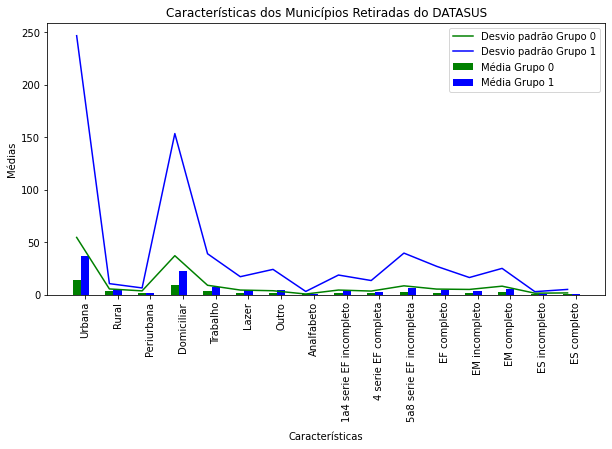

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

g0 = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g0_describe.csv', delimiter = ',')
g1 = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g1_describe.csv', delimiter = ',')

g0 = g0.drop(columns=['Unnamed: 0','Ign/Branco_x','Ign/Branco_y','Ign/Branco_z','Nao se aplica','Cod Mun','Densidade Populacional','Total','freq_rel'])
g1 = g1.drop(columns=['Unnamed: 0','Ign/Branco_x','Ign/Branco_y','Ign/Branco_z','Nao se aplica','Cod Mun','Densidade Populacional','Total','freq_rel'])
cols = g0.columns

g0_list = list(g0.iloc[1]) #linha da média
g1_list = list(g1.iloc[1]) #linha da média

g0_dp= list(g0.iloc[2])
g1_dp= list(g1.iloc[2])
# Definindo a Largura das barras
barWidth = 0.25

# Aumentando o gráfico
plt.figure(figsize=(10,5))

# Definindo a posição das barras
r1 = np.arange(len(g0_list))
r2 = [x + barWidth for x in r1]

#Criando as barras
plt.bar(r1, g0_list, color='green', width=barWidth, label='Média Grupo 0')
plt.bar(r2, g1_list, color='blue', width=barWidth, label='Média Grupo 1')

plt.plot(g0_dp,color='green',label='Desvio padrão Grupo 0')
plt.plot(g1_dp,color='blue',label='Desvio padrão Grupo 1')

plt.xlabel('Características',labelpad=10)

plt.xticks([r + barWidth for r in range(len(g0_list))], cols, rotation=90)
plt.ylabel('Médias')

plt.title('Características dos Municípios Retiradas do DATASUS')
# Criando a Legenda e exibindo o gráfico

plt.legend()
plt.savefig('drive/MyDrive/BK_Seg/Dados TCC II/caract.png',bbox_inches ='tight',pad_inches=0.5)
plt.show()


In [ ]:
import pandas as pd

g0 = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g0_describe.csv', delimiter = ',')
g1 = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/Correlações/g1_describe.csv', delimiter = ',')
cols = [ 'Ign/Branco_x', 'Urbana', 'Rural', 'Periurbana',
       'Ign/Branco_y', 'Domiciliar', 'Trabalho', 'Lazer', 'Outro',
       'Ign/Branco_z', 'Analfabeto', '1a4 serie EF incompleto',
       '4 serie EF completa', '5a8 serie EF incompleta', 'EF completo',
       'EM incompleto', 'EM completo', 'ES incompleto', 'ES completo',
       'Nao se aplica', 'Cod Mun']
# print(g0)
g0_new = g0.drop(columns = cols)
g1_new = g1.drop(columns = cols)
print('g0')
print(g0_new)
print('g1')
print(g1_new)

# silhueta do complete_2 => 0.958653
# montar tabela no LaTex

g0
  Unnamed: 0       Total  Densidade Populacional    freq_rel
0      count  187.000000              187.000000  187.000000
1       mean   22.898396              625.072941    0.703676
2        std   68.198834             1830.488965    0.037836
3        min    1.000000                7.680000    0.561500
4        25%    1.000000               45.650000    0.679500
5        50%    5.000000              122.000000    0.705500
6        75%   17.500000              283.325000    0.734000
7        max  748.000000            13704.770000    0.783000
g1
  Unnamed: 0        Total  Densidade Populacional    freq_rel
0      count   104.000000              104.000000  104.000000
1       mean    52.096154              731.229231    0.711375
2        std   302.603028             1952.883312    0.043209
3        min     1.000000                8.630000    0.609500
4        25%     2.000000               49.560000    0.678500
5        50%     4.000000              102.890000    0.712750
6        75

Início das visualizações:

In [ ]:
#visualização da curva do cotovelo
from sklearn.cluster import KMeans
# !pip install matplotlib
import matplotlib.pyplot as plt

df = pd.read_csv('drive/MyDrive/BK_Seg/Dados TCC II/CSVs/renom.csv', delimiter = ',')

#removendo colunas que não participam da análise computacional 
matriz_hierarquica = df.drop(columns=['Unnamed: 0','Cod Mun','Municipio']) #remove coluna de indices

matriz_hierarquica = matriz_hierarquica.drop(matriz_hierarquica.index[290]) #linha removida temporariamente para teste (está sem a densidade pop -> adicionar)

#chama função que normaliza os dados
data_norm1,data_norm2,data_norm3,data_norm4,data_norm5 = normalizacao(matriz_hierarquica)
#cria dicionario com as diferentes normalizações, inclusive sem normalização (raw)
data_norm_dic = {'raw':matriz_hierarquica.to_numpy(),'norm1':data_norm1.to_numpy(),'norm2':data_norm2.to_numpy(),'norm3':data_norm3.to_numpy(),'norm4':data_norm4.to_numpy(),'norm5':data_norm5.to_numpy()}

wcss = [] #within-cluster-sum-of-squares

for key, value in data_norm_dic.items():
  for k in range(1,8):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10)
    kmeans.fit(value)
    wcss.append(kmeans.inertia_)
  plt.plot(range(1,8),wcss)
  plt.title("Método Cotovelo")
  plt.xlabel("Número de Clusters")
  plt.ylabel("Within-Cluster-Sum-of-Squares")
  plt.show()
  wcss.clear()

In [ ]:
import pandas as pd
import seaborn as sns

df_reg = pd.DataFrame(index=range(0,6),columns=['Densidade','IDHM','GINI','Total'])
df_reg.iloc[0] = [4122.45,0.745,0.6414,1000]
df_reg.iloc[1] = [10977.94,0.741,0.5136,1000]
df_reg.iloc[2] = [7732.31,0.769,0.6113,1000]
df_reg.iloc[3] = [4188.78,0.720,0.523,1000]
df_reg.iloc[4] = [4387.46,0.653,0.4615,1000]
df_reg.iloc[5] = [583.71,0.742,0.5587,1000]
# correlacao = (df_reg[].corrwith()).copy()
GINI = df_reg.drop(columns=['Densidade','IDHM']).copy()
# print(GINI)
OUTROS = df_reg.drop(columns=['GINI']).copy()
# print(OUTROS)
# correlacao=OUTROS.corrwith(GINI).copy()
# print(correlacao)
# p1 = sns.heatmap(df_reg)
print(df_reg.corr())

Series([], dtype: float64)
